# EDA

In [390]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import snscrape.modules.twitter as sntwitter
from pathlib import Path  
import re
import string
from transformers import AutoTokenizer
#add package
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from textblob import TextBlob

In [391]:
# requirements 
# wordcloud
# scipy
# transformers
# tqdm
# matplotlib
# nltk
#textblob

In [392]:
vaccine_df_2020_2021 = pd.read_csv(r'data/vaccine_output_2020_2021.csv')

#vaccine_df_2021_2022 = pd.read_csv(r'data/vaccine_output_2021_2022.csv')

In [393]:
vaccine_df_2020_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  996 non-null    int64 
 1   Date        996 non-null    object
 2   User        996 non-null    object
 3   Tweet       996 non-null    object
 4   Tweet_URL   996 non-null    object
 5   Location    785 non-null    object
dtypes: int64(1), object(5)
memory usage: 46.8+ KB


In [394]:
print(vaccine_df_2020_2021.shape)

(996, 6)


In [395]:
vaccine_df_2020_2021.head()

Unnamed: 0                       Date          User  \
0           0  2021-12-07 23:58:57+00:00    TPedherney   
1           1  2021-12-07 23:32:39+00:00    cwillits30   
2           2  2021-12-07 23:29:36+00:00       MA_CEAL   
3           3  2021-12-07 23:08:19+00:00     WebAeneas   
4           4  2021-12-07 23:02:41+00:00  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                           Tweet_URL               Location  
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON  
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ  
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts  
3  https://twitter.com/WebAeneas/status/146835672...                    NaN  
4  https://twitter.com/TheAmirImani/status/146835...                Toronto

### PREPROCESSING TWEETS

In [396]:
# clean and filter using SPARK
def preprocessing(df):
    location_df = df['Location']
    #tweet_lower_df = df['Tweet'].str.lower()
    EMOJI_PATTERN = re.compile( \
                           "[" \
                           "\U0001F1E0-\U0001F1FF"  \
                           "\U0001F300-\U0001F5FF"  \
                           "\U0001F600-\U0001F64F"  \
                           "\U0001F680-\U0001F6FF"  \
                           "\U0001F700-\U0001F77F" \
                           "\U0001F780-\U0001F7FF" \
                           "\U0001F800-\U0001F8FF" \
                           "\U0001F900-\U0001F9FF" \
                           "\U0001FA00-\U0001FA6F" \
                           "\U0001FA70-\U0001FAFF" \
                           "\U00002702-\U000027B0" \
                           "\U000024C2-\U0001F251" \
                           "]+")
    
    tweet_whitespace_df = df['Tweet'].replace(r'\s+',' ',regex=True)
    #tweet_emoji_df = tweet_whitespace_df.replace(EMOJI_PATTERN,'',regex = True)
    tweet_hashtag_df = tweet_whitespace_df.replace(r'#','',regex=True)
    tweet_numbers_df = tweet_hashtag_df.replace(r'[0-9]+', '', regex = True)
    tweet_amp_df = tweet_numbers_df.replace(r'&amp;', '', regex = True)
    tweet_reply_df = tweet_amp_df.replace(r'@[^\s]+', '', regex = True)
    
    #tweet_punc_df = tweet_numbers_df.replace(r'[^\w\s]', '', regex = True)
    
    
    location_whitespace_df =  location_df.replace(r'\s+',' ',regex=True)
    location_hashtag_df = location_whitespace_df.replace(r'#','',regex=True)
    location_numbers_df = location_hashtag_df.replace(r'[0-9]+','',regex=True)
    location_emoji_df = location_numbers_df.replace(EMOJI_PATTERN,'',regex = True)
    PUNCT_MODIFIED = r'[.|!|#|\"|$|%|\'|\(|\)|*|+|=|<|>|~|\{|\}|\\|/|:|;|\?|@|\[|^|_|\`|\]]'
    location_punc_df = location_emoji_df.replace(PUNCT_MODIFIED,'',regex = True)
    return tweet_reply_df,location_punc_df


In [397]:
vaccine_20_21_cleanedDF = vaccine_df_2020_2021
vaccine_20_21_cleanedDF['Processed_Tweet'],vaccine_20_21_cleanedDF['Location'] = preprocessing(vaccine_df_2020_2021)
vaccine_20_21_cleanedDF['Location'] = vaccine_20_21_cleanedDF['Location'].fillna('')
vaccine_20_21_cleanedDF

Unnamed: 0                       Date           User  \
0             0  2021-12-07 23:58:57+00:00     TPedherney   
1             1  2021-12-07 23:32:39+00:00     cwillits30   
2             2  2021-12-07 23:29:36+00:00        MA_CEAL   
3             3  2021-12-07 23:08:19+00:00      WebAeneas   
4             4  2021-12-07 23:02:41+00:00   TheAmirImani   
..          ...                        ...            ...   
991         995  2021-12-04 04:19:51+00:00  AnoopChathoth   
992         996  2021-12-04 04:19:26+00:00    nemahinemla   
993         997  2021-12-04 04:17:29+00:00    DonielOediv   
994         998  2021-12-04 04:12:27+00:00  billlionnaire   
995         999  2021-12-04 04:11:39+00:00   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4    https://twitter.com/TheAmirImani/status/146835...   
..                                                 ...   
991  https://twitter.com/AnoopChathoth/status/14669...   
992  https://twitter.com/nemahinemla/status/1466985...   
993  https://twitter.com/DonielOediv/status/1466984...   
994  https://twitter.com/billlionnaire/status/14669...   
995  https://twitter.com/ashifrazaiyc/status/146698...   

                       Location  \
0                Burlington, ON   
1                   Phoenix, AZ   
2         Boston, Massachusetts   
3                                 
4                       Toronto   
..                          ...   
991  Bangalore  Kannur  Wayanad   
992                   Nisqually   
993                          nz   
994                               
995          Rajgangpur, odisha   

                                       Processed_Tweet  
0     In line to get my booster vaccine Booster Pfizer  
1    Officially boosted! First done of Moderna afte...  
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...  
3    vaccinated another great idea you can sue anyo...  
4    I don't know if this is a " dose vaccine" or a...  
..                                                 ...  
991  Kerala has  teaching and non teaching staff wh...  
992  Nisqually Indian Tribe mandates CovidVaccine f...  
993  i feel like throwing up  hours after taking se...  
994  What Covid denial don't get it. They have had ...  
995  All The Health Workers In India Should Be Give...  

[996 rows x 7 columns]

In [398]:
#Rearrange columns
col_list = vaccine_20_21_cleanedDF.columns.tolist()
cols = col_list[:-3] + col_list[-1:] + col_list[4:6]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF[cols]
vaccine_20_21_cleanedDF = vaccine_20_21_cleanedDF.rename({'Unnamed: 0': 'ID'}, axis=1) 
vaccine_20_21_cleanedDF.columns.tolist()

['ID', 'Date', 'User', 'Tweet', 'Processed_Tweet', 'Tweet_URL', 'Location']

In [399]:
vaccine_20_21_cleanedDF.to_csv(r'data/new_processed.csv', encoding='utf-8')

In [400]:
vaccine_20_21_cleanedDF.head()

ID                       Date          User  \
0   0  2021-12-07 23:58:57+00:00    TPedherney   
1   1  2021-12-07 23:32:39+00:00    cwillits30   
2   2  2021-12-07 23:29:36+00:00       MA_CEAL   
3   3  2021-12-07 23:08:19+00:00     WebAeneas   
4   4  2021-12-07 23:02:41+00:00  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                     Processed_Tweet  \
0   In line to get my booster vaccine Booster Pfizer   
1  Officially boosted! First done of Moderna afte...   
2  COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3  vaccinated another great idea you can sue anyo...   
4  I don't know if this is a " dose vaccine" or a...   

                                           Tweet_URL               Location  
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON  
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ  
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts  
3  https://twitter.com/WebAeneas/status/146835672...                         
4  https://twitter.com/TheAmirImani/status/146835...                Toronto

(-0.5, 399.5, 199.5, -0.5)

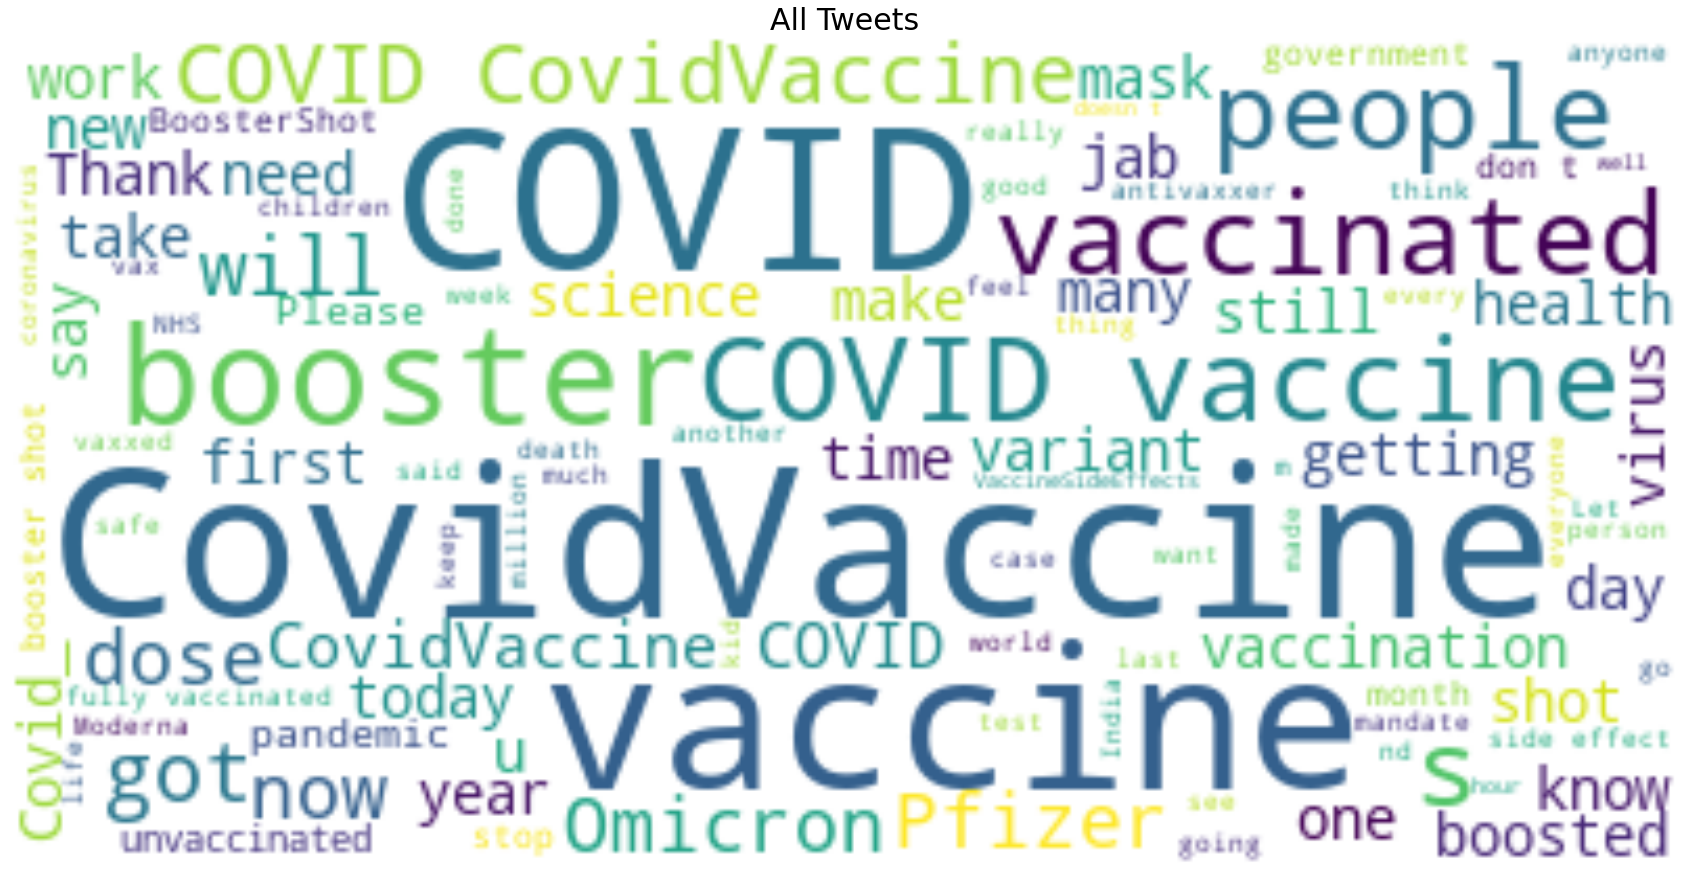

In [401]:

tweet_All = " ".join(review for review in vaccine_20_21_cleanedDF['Processed_Tweet'])

fig, ax = plt.subplots(1, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)


# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)
ax.axis('off')


The Most Frequent words are 'CovidVaccine , Covid , Virus , Omicron ' Occurs almost in all the sentances , this along with the stop words wouldnt affect the performance of algorithms but words like Pfizer Moderna can help us determine the popular vaccine , and words such as "side effect  , death " can help us tag misinformed tweets about covid vaccine 

## ALGORITHMS

#### Basic NLTK Operations

In [402]:
sample = vaccine_20_21_cleanedDF['Processed_Tweet'][9]
print(sample)

#VADER 
#ROBERTA
#Compare and visualize 
#Pipeline for current tweet

yo  "You ruined my life"  "you're so mean" as got nd CovidVaccine shot. That's my job though, helping keep him, those like me with autoimmune issues,  everyone else safe as possible. Also yelled "I liked it better when there was no COVID!" Me too, bud, Me too


In [403]:
from nltk.tokenize import TweetTokenizer

tokens = TweetTokenizer().tokenize(sample)
print(tokens)

['yo', '"', 'You', 'ruined', 'my', 'life', '"', '"', "you're", 'so', 'mean', '"', 'as', 'got', 'nd', 'CovidVaccine', 'shot', '.', "That's", 'my', 'job', 'though', ',', 'helping', 'keep', 'him', ',', 'those', 'like', 'me', 'with', 'autoimmune', 'issues', ',', 'everyone', 'else', 'safe', 'as', 'possible', '.', 'Also', 'yelled', '"', 'I', 'liked', 'it', 'better', 'when', 'there', 'was', 'no', 'COVID', '!', '"', 'Me', 'too', ',', 'bud', ',', 'Me', 'too']


In [404]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('yo', 'RB'), ('"', 'NNP'), ('You', 'PRP'), ('ruined', 'VBD'), ('my', 'PRP$'), ('life', 'NN'), ('"', 'NNP'), ('"', 'NNP'), ("you're", 'NNP'), ('so', 'IN'), ('mean', 'JJ'), ('"', 'NN'), ('as', 'IN'), ('got', 'VBD'), ('nd', 'JJ'), ('CovidVaccine', 'NNP'), ('shot', 'NN'), ('.', '.'), ("That's", 'NNP'), ('my', 'PRP$'), ('job', 'NN'), ('though', 'IN'), (',', ','), ('helping', 'VBG'), ('keep', 'VB'), ('him', 'PRP'), (',', ','), ('those', 'DT'), ('like', 'IN'), ('me', 'PRP'), ('with', 'IN'), ('autoimmune', 'JJ'), ('issues', 'NNS'), (',', ','), ('everyone', 'NN'), ('else', 'RB'), ('safe', 'JJ'), ('as', 'IN'), ('possible', 'JJ'), ('.', '.'), ('Also', 'RB'), ('yelled', 'VBD'), ('"', 'NN'), ('I', 'PRP'), ('liked', 'VBD'), ('it', 'PRP'), ('better', 'RBR'), ('when', 'WRB'), ('there', 'EX'), ('was', 'VBD'), ('no', 'DT'), ('COVID', 'NNP'), ('!', '.'), ('"', 'VB'), ('Me', 'NNP'), ('too', 'RB'), (',', ','), ('bud', 'NN'), (',', ','), ('Me', 'NNP'), ('too', 'RB')]


In [405]:
#chunked into a sentance
Chunked_sentence_entities = nltk.chunk.ne_chunk(tagged)
Chunked_sentence_entities.pprint()

(S
  yo/RB
  "/NNP
  You/PRP
  ruined/VBD
  my/PRP$
  life/NN
  "/NNP
  "/NNP
  you're/NNP
  so/IN
  mean/JJ
  "/NN
  as/IN
  got/VBD
  nd/JJ
  (ORGANIZATION CovidVaccine/NNP)
  shot/NN
  ./.
  That's/NNP
  my/PRP$
  job/NN
  though/IN
  ,/,
  helping/VBG
  keep/VB
  him/PRP
  ,/,
  those/DT
  like/IN
  me/PRP
  with/IN
  autoimmune/JJ
  issues/NNS
  ,/,
  everyone/NN
  else/RB
  safe/JJ
  as/IN
  possible/JJ
  ./.
  Also/RB
  yelled/VBD
  "/NN
  I/PRP
  liked/VBD
  it/PRP
  better/RBR
  when/WRB
  there/EX
  was/VBD
  no/DT
  COVID/NNP
  !/.
  "/VB
  (PERSON Me/NNP)
  too/RB
  ,/,
  bud/NN
  ,/,
  (PERSON Me/NNP)
  too/RB)


### TEXT BLOB

In [406]:
def TextBlob_score(tweet):
    # This polarity score is between -1 to 1
    polarity = TextBlob(tweet).sentiment.polarity
    if polarity < 0:
        sentiment = 'neg'
    elif score == 0:
        sentiment = 'neu'
    else:
        sentiment = 'pos'

    return polarity,sentiment
def TextBlob_subjectivity(tweet):
    
    subjectivity = TextBlob(tweet).sentiment.subjectivity
    return subjectivity


In [407]:
score,sentiment = TextBlob_score(sample)
print(score)
print(sentiment)

0.28250000000000003
pos


In [408]:
sub = TextBlob_subjectivity(sample)
sub

0.6975

### VADER

In [409]:
Sentiment_analyzer = SentimentIntensityAnalyzer()
result_vader = Sentiment_analyzer.polarity_scores(sample)
result_vader


{'neg': 0.09, 'neu': 0.679, 'pos': 0.231, 'compound': 0.807}

In [410]:
nltk.download("vader_lexicon")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/preethi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## ROBERTA TRANSFORMERS

In [411]:
#Hugging face - it will pull the model weights that are stored - transfer learning , we don't have to retrain the model at all
#it downloads all of the weights
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [412]:
#vader results
print(sample)
Sentiment_analyzer.polarity_scores(sample)

yo  "You ruined my life"  "you're so mean" as got nd CovidVaccine shot. That's my job though, helping keep him, those like me with autoimmune issues,  everyone else safe as possible. Also yelled "I liked it better when there was no COVID!" Me too, bud, Me too


{'neg': 0.09, 'neu': 0.679, 'pos': 0.231, 'compound': 0.807}

In [413]:
#Run on Roberta Model
#encoding the text
#'pt' - pytorch
encoded_text = tokenizer(sample,return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0,  9839,  1437,    22,  1185, 19750,   127,   301,   113,  1437,
            22,  6968,   214,    98,  1266,   113,    25,   300,   295,   417,
         19150,   808,   846,  7904,   833,   738,     4,   280,    18,   127,
           633,   600,     6,  1903,   489,   123,     6,   167,   101,   162,
            19, 35617,   743,     6,  1437,   961,  1493,  1522,    25,   678,
             4,  1578, 19475,    22,   100,  6640,    24,   357,    77,    89,
            21,   117,  6247, 43814,  2901,  1464,   350,     6, 18464,     6,
          1464,   350,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]])}

In [414]:
output = model(**encoded_text)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0234,  0.2982, -0.3754]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [415]:
scores = output[0][0].detach().numpy()
scores


array([ 0.02344084,  0.29824632, -0.37542567], dtype=float32)

In [416]:
softmax_scores = softmax(scores)
softmax_scores

array([0.33474427, 0.44061545, 0.22464027], dtype=float32)

In [417]:
scores_dict = {
    'roberta_neg' : softmax_scores[0],
    'roberta_neu' : softmax_scores[1],
    'roberta_pos' : softmax_scores[2]
}
print(scores_dict)

{'roberta_neg': 0.33474427, 'roberta_neu': 0.44061545, 'roberta_pos': 0.22464027}


### Combining all three models to compare results

In [418]:
Tweet_vaders_sentiment.head()

ID    neg    neu    pos  compound                       Date          User  \
0   0  0.000  1.000  0.000    0.0000  2021-12-07 23:58:57+00:00    TPedherney   
1   1  0.000  0.770  0.230    0.6884  2021-12-07 23:32:39+00:00    cwillits30   
2   2  0.143  0.746  0.111   -0.3579  2021-12-07 23:29:36+00:00       MA_CEAL   
3   3  0.075  0.719  0.206    0.6581  2021-12-07 23:08:19+00:00     WebAeneas   
4   4  0.099  0.810  0.091   -0.1027  2021-12-07 23:02:41+00:00  TheAmirImani   

                                               Tweet  \
0  In line to get my booster #vaccine #Booster #P...   
1  Officially boosted! First done of Moderna afte...   
2  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3  #vaccinated another great idea you can sue any...   
4  I don't know if this is a "3 dose #vaccine" or...   

                                     Processed_Tweet  \
0   In line to get my booster vaccine Booster Pfizer   
1  Officially boosted! First done of Moderna afte...   
2  COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3  vaccinated another great idea you can sue anyo...   
4  I don't know if this is a " dose vaccine" or a...   

                                           Tweet_URL               Location  \
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON   
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ   
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts   
3  https://twitter.com/WebAeneas/status/146835672...                          
4  https://twitter.com/TheAmirImani/status/146835...                Toronto   

   Vader_Sentiment_Score Vader_Sentiment  
0                  1.000             neu  
1                  0.770             neu  
2                  0.746             neu  
3                  0.719             neu  
4                  0.810             neu

In [419]:
def roberta_polarity_scores(sample):
    encoded = tokenizer(sample,return_tensors='pt')
    output = model(**encoded)
    scores=output[0][0].detach().numpy()
    softmax_scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : softmax_scores[0],
        'roberta_neu' : softmax_scores[1],
        'roberta_pos' : softmax_scores[2]
    }
    return scores_dict


In [420]:
#iterate over the dataset to calculate scores for each example
# some size of the text is too big for the roberta model to handle , we can skip those by adding try
result = {}
final_result={}
for i,row in tqdm(vaccine_20_21_cleanedDF.iterrows(),total=len(vaccine_20_21_cleanedDF)):
    try:
        tweet = row['Processed_Tweet']
        id = row['ID']

        vader_result = Sentiment_analyzer.polarity_scores(tweet)
        score = TextBlob(tweet).sentiment.polarity
        subjectivity = TextBlob(tweet).sentiment.subjectivity
        if score < 0:
            sentiment = 'neg'
        elif score == 0:
            sentiment = 'neu'
        else:
            sentiment = 'pos'
        
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        

        roberta_result = roberta_polarity_scores(tweet)
        
        text_blob_result = {}
        Text_Blob_result = {'Text_blob_score' :score , 'Text_blob_subjectivity' :subjectivity,'Text_blob_sentiment' : sentiment}


        #combining three dictionaries
        combined_result = {**vader_result,**roberta_result,**Text_Blob_result}
        #break
        result[id] = combined_result
    except RuntimeError:
        print(f'Text size too long for id: {id}')



  0%|          | 0/996 [00:00<?, ?it/s]

In [421]:
Tweet_Roberta =  pd.DataFrame(result).T
#Tweet_Roberta
Tweet_Roberta


neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2    0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3    0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4    0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..     ...    ...    ...      ...         ...         ...         ...   
995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  
0               0.0                    0.0                 neu  
1          0.417969               0.541667                 pos  
2               0.0                    0.0                 neu  
3          0.266667                   0.55                 pos  
4              0.05                    0.2                 pos  
..              ...                    ...                 ...  
995             0.0                    0.0                 neu  
996             0.0                    0.0                 neu  
997             0.0                    0.0                 neu  
998             0.3                   0.75                 pos  
999             0.0                    0.0                 neu  

[996 rows x 10 columns]

In [422]:
Tweet_Roberta = Tweet_Roberta.reset_index().rename(columns={'index':'ID'})
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  
0               0.0                    0.0                 neu  
1          0.417969               0.541667                 pos  
2               0.0                    0.0                 neu  
3          0.266667                   0.55                 pos  
4              0.05                    0.2                 pos  
..              ...                    ...                 ...  
991             0.0                    0.0                 neu  
992             0.0                    0.0                 neu  
993             0.0                    0.0                 neu  
994             0.3                   0.75                 pos  
995             0.0                    0.0                 neu  

[996 rows x 11 columns]

In [423]:
Tweet_Roberta = Tweet_Roberta.merge(vaccine_20_21_cleanedDF,how = 'left')

In [424]:
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0               0.0                    0.0                 neu   
1          0.417969               0.541667                 pos   
2               0.0                    0.0                 neu   
3          0.266667                   0.55                 pos   
4              0.05                    0.2                 pos   
..              ...                    ...                 ...   
991             0.0                    0.0                 neu   
992             0.0                    0.0                 neu   
993             0.0                    0.0                 neu   
994             0.3                   0.75                 pos   
995             0.0                    0.0                 neu   

                          Date           User  \
0    2021-12-07 23:58:57+00:00     TPedherney   
1    2021-12-07 23:32:39+00:00     cwillits30   
2    2021-12-07 23:29:36+00:00        MA_CEAL   
3    2021-12-07 23:08:19+00:00      WebAeneas   
4    2021-12-07 23:02:41+00:00   TheAmirImani   
..                         ...            ...   
991  2021-12-04 04:19:51+00:00  AnoopChathoth   
992  2021-12-04 04:19:26+00:00    nemahinemla   
993  2021-12-04 04:17:29+00:00    DonielOediv   
994  2021-12-04 04:12:27+00:00  billlionnaire   
995  2021-12-04 04:11:39+00:00   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4  

In [425]:
Tweet_Roberta['Vader_Sentiment_Score'] =  Tweet_Roberta[["neg", "neu","pos"]].max(axis=1)
Tweet_Roberta_sentiment = Tweet_Roberta
Tweet_Roberta

ID    neg    neu    pos compound roberta_neg roberta_neu roberta_pos  \
0      0    0.0    1.0    0.0      0.0    0.022098    0.886437    0.091465   
1      1    0.0   0.77   0.23   0.6884     0.00216    0.138659    0.859182   
2      2  0.143  0.746  0.111  -0.3579    0.513322    0.387588     0.09909   
3      3  0.075  0.719  0.206   0.6581    0.635788    0.291731    0.072481   
4      4  0.099   0.81  0.091  -0.1027    0.424267    0.533392    0.042342   
..   ...    ...    ...    ...      ...         ...         ...         ...   
991  995  0.048  0.918  0.033  -0.1531    0.707394    0.277628    0.014977   
992  996    0.0    1.0    0.0      0.0    0.067002    0.907798      0.0252   
993  997    0.0  0.828  0.172   0.3612    0.930836    0.062937    0.006226   
994  998  0.118  0.882    0.0  -0.5859    0.850514    0.135886      0.0136   
995  999    0.0  0.884  0.116   0.3612    0.080648    0.754077    0.165275   

    Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0               0.0                    0.0                 neu   
1          0.417969               0.541667                 pos   
2               0.0                    0.0                 neu   
3          0.266667                   0.55                 pos   
4              0.05                    0.2                 pos   
..              ...                    ...                 ...   
991             0.0                    0.0                 neu   
992             0.0                    0.0                 neu   
993             0.0                    0.0                 neu   
994             0.3                   0.75                 pos   
995             0.0                    0.0                 neu   

                          Date           User  \
0    2021-12-07 23:58:57+00:00     TPedherney   
1    2021-12-07 23:32:39+00:00     cwillits30   
2    2021-12-07 23:29:36+00:00        MA_CEAL   
3    2021-12-07 23:08:19+00:00      WebAeneas   
4    2021-12-07 23:02:41+00:00   TheAmirImani   
..                         ...            ...   
991  2021-12-04 04:19:51+00:00  AnoopChathoth   
992  2021-12-04 04:19:26+00:00    nemahinemla   
993  2021-12-04 04:17:29+00:00    DonielOediv   
994  2021-12-04 04:12:27+00:00  billlionnaire   
995  2021-12-04 04:11:39+00:00   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://twitter.com/WebAeneas/status/146835672...   
4  

In [426]:
Tweet_Roberta_sentiment["neg"] = pd.to_numeric(Tweet_Roberta_sentiment["neg"])
Tweet_Roberta_sentiment["pos"] = pd.to_numeric(Tweet_Roberta_sentiment["pos"])
Tweet_Roberta_sentiment["neu"] = pd.to_numeric(Tweet_Roberta_sentiment["neu"])
Tweet_Roberta_sentiment["compound"] = pd.to_numeric(Tweet_Roberta_sentiment["compound"])
Tweet_Roberta_sentiment["roberta_neg"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_neg"])
Tweet_Roberta_sentiment["roberta_pos"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_pos"])
Tweet_Roberta_sentiment["roberta_neu"] = pd.to_numeric(Tweet_Roberta_sentiment["roberta_neu"])
Tweet_Roberta_sentiment['Vader_Sentiment'] = Tweet_Roberta_sentiment[["neg", "neu","pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment

ID    neg    neu    pos  compound  roberta_neg  roberta_neu  \
0      0  0.000  1.000  0.000    0.0000     0.022098     0.886437   
1      1  0.000  0.770  0.230    0.6884     0.002160     0.138659   
2      2  0.143  0.746  0.111   -0.3579     0.513322     0.387588   
3      3  0.075  0.719  0.206    0.6581     0.635788     0.291731   
4      4  0.099  0.810  0.091   -0.1027     0.424267     0.533392   
..   ...    ...    ...    ...       ...          ...          ...   
991  995  0.048  0.918  0.033   -0.1531     0.707394     0.277628   
992  996  0.000  1.000  0.000    0.0000     0.067002     0.907798   
993  997  0.000  0.828  0.172    0.3612     0.930836     0.062937   
994  998  0.118  0.882  0.000   -0.5859     0.850514     0.135886   
995  999  0.000  0.884  0.116    0.3612     0.080648     0.754077   

     roberta_pos Text_blob_score Text_blob_subjectivity Text_blob_sentiment  \
0       0.091465             0.0                    0.0                 neu   
1       0.859182        0.417969               0.541667                 pos   
2       0.099090             0.0                    0.0                 neu   
3       0.072481        0.266667                   0.55                 pos   
4       0.042342            0.05                    0.2                 pos   
..           ...             ...                    ...                 ...   
991     0.014977             0.0                    0.0                 neu   
992     0.025200             0.0                    0.0                 neu   
993     0.006226             0.0                    0.0                 neu   
994     0.013600             0.3                   0.75                 pos   
995     0.165275             0.0                    0.0                 neu   

                          Date           User  \
0    2021-12-07 23:58:57+00:00     TPedherney   
1    2021-12-07 23:32:39+00:00     cwillits30   
2    2021-12-07 23:29:36+00:00        MA_CEAL   
3    2021-12-07 23:08:19+00:00      WebAeneas   
4    2021-12-07 23:02:41+00:00   TheAmirImani   
..                         ...            ...   
991  2021-12-04 04:19:51+00:00  AnoopChathoth   
992  2021-12-04 04:19:26+00:00    nemahinemla   
993  2021-12-04 04:17:29+00:00    DonielOediv   
994  2021-12-04 04:12:27+00:00  billlionnaire   
995  2021-12-04 04:11:39+00:00   ashifrazaiyc   

                                                 Tweet  \
0    In line to get my booster #vaccine #Booster #P...   
1    Officially boosted! First done of Moderna afte...   
2    #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3    #vaccinated another great idea you can sue any...   
4    I don't know if this is a "3 dose #vaccine" or...   
..                                                 ...   
991  #Kerala has 1707 teaching and non teaching sta...   
992  Nisqually Indian Tribe mandates #CovidVaccine ...   
993  i feel like throwing up 52 hours after taking ...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                       Processed_Tweet  \
0     In line to get my booster vaccine Booster Pfizer   
1    Officially boosted! First done of Moderna afte...   
2    COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3    vaccinated another great idea you can sue anyo...   
4    I don't know if this is a " dose vaccine" or a...   
..                                                 ...   
991  Kerala has  teaching and non teaching staff wh...   
992  Nisqually Indian Tribe mandates CovidVaccine f...   
993  i feel like throwing up  hours after taking se...   
994  What Covid denial don't get it. They have had ...   
995  All The Health Workers In India Should Be Give...   

                                             Tweet_URL  \
0    https://twitter.com/TPedherney/status/14683694...   
1    https://twitter.com/cwillits30/status/14683628...   
2    https://twitter.com/MA_CEAL/status/14683620841...   
3    https://

In [427]:
Tweet_Roberta_sentiment['Roberta_Sentiment_Score'] =  Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].max(axis=1)
Tweet_Roberta_sentiment_1 = Tweet_Roberta_sentiment
Tweet_Roberta_sentiment_1['Roberta_Sentiment'] = Tweet_Roberta_sentiment[["roberta_neg", "roberta_neu","roberta_pos"]].idxmax(axis=1)
Tweet_Roberta_sentiment_1.head()

ID    neg    neu    pos  compound  roberta_neg  roberta_neu  roberta_pos  \
0   0  0.000  1.000  0.000    0.0000     0.022098     0.886437     0.091465   
1   1  0.000  0.770  0.230    0.6884     0.002160     0.138659     0.859182   
2   2  0.143  0.746  0.111   -0.3579     0.513322     0.387588     0.099090   
3   3  0.075  0.719  0.206    0.6581     0.635788     0.291731     0.072481   
4   4  0.099  0.810  0.091   -0.1027     0.424267     0.533392     0.042342   

  Text_blob_score Text_blob_subjectivity  ...                       Date  \
0             0.0                    0.0  ...  2021-12-07 23:58:57+00:00   
1        0.417969               0.541667  ...  2021-12-07 23:32:39+00:00   
2             0.0                    0.0  ...  2021-12-07 23:29:36+00:00   
3        0.266667                   0.55  ...  2021-12-07 23:08:19+00:00   
4            0.05                    0.2  ...  2021-12-07 23:02:41+00:00   

           User                                              Tweet  \
0    TPedherney  In line to get my booster #vaccine #Booster #P...   
1    cwillits30  Officially boosted! First done of Moderna afte...   
2       MA_CEAL  #COVIDMythBustingTuesdays! Myth: Doesn’t the #...   
3     WebAeneas  #vaccinated another great idea you can sue any...   
4  TheAmirImani  I don't know if this is a "3 dose #vaccine" or...   

                                     Processed_Tweet  \
0   In line to get my booster vaccine Booster Pfizer   
1  Officially boosted! First done of Moderna afte...   
2  COVIDMythBustingTuesdays! Myth: Doesn’t the CO...   
3  vaccinated another great idea you can sue anyo...   
4  I don't know if this is a " dose vaccine" or a...   

                                           Tweet_URL               Location  \
0  https://twitter.com/TPedherney/status/14683694...         Burlington, ON   
1  https://twitter.com/cwillits30/status/14683628...            Phoenix, AZ   
2  https://twitter.com/MA_CEAL/status/14683620841...  Boston, Massachusetts   
3  https://twitter.com/WebAeneas/status/146835672...                          
4  https://twitter.com/TheAmirImani/status/146835...                Toronto   

  Vader_Sentiment_Score  Vader_Sentiment Roberta_Sentiment_Score  \
0                 1.000              neu                0.886437   
1                 0.770              neu                0.859182   
2                 0.746              neu                0.513322   
3                 0.719              neu                0.635788   
4                 0.810              neu                0.533392   

   Roberta_Sentiment  
0        roberta_neu  
1        roberta_pos  
2        roberta_neg  
3        roberta_neg  
4        roberta_neu  

[5 rows x 21 columns]

In [437]:
sentiment_counts = Tweet_Roberta_sentiment_1.groupby(['Vader_Sentiment']).size()
print(sentiment_counts)



Vader_Sentiment
neg      4
neu    982
pos     10
dtype: int64


<AxesSubplot:>

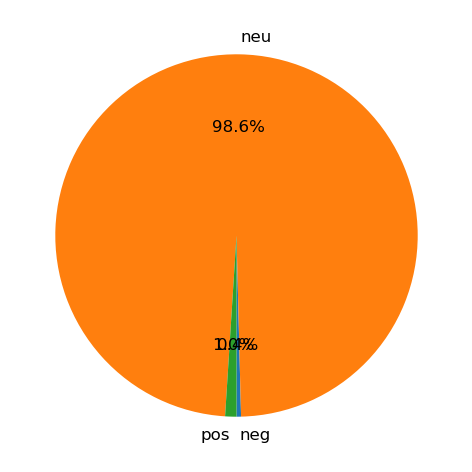

In [438]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")


In [430]:
sentiment_counts_roberta = Tweet_Roberta_sentiment_1.groupby(['Roberta_Sentiment']).size()
print(sentiment_counts_roberta)

Roberta_Sentiment
roberta_neg    484
roberta_neu    334
roberta_pos    178
dtype: int64


<AxesSubplot:>

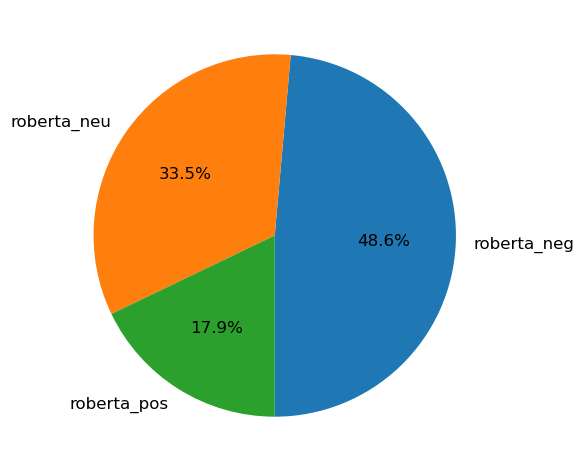

In [431]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts_roberta.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [432]:
sentiment_counts_text_blob = Tweet_Roberta_sentiment_1.groupby(['Text_blob_sentiment']).size()
print(sentiment_counts_text_blob)

Text_blob_sentiment
neg    256
neu    292
pos    448
dtype: int64


<AxesSubplot:>

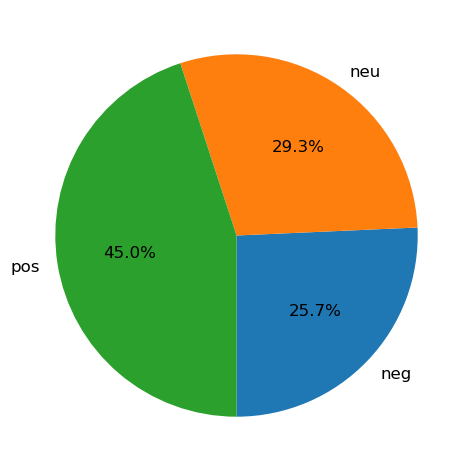

In [433]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts_text_blob.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

In [434]:
#rearrange 
Tweet_Roberta_sentiment_1.to_csv(r'data/sentiment.csv', encoding='utf-8')

## Manufacturers 

In [435]:
def GetManufacturer(tweet):
    tweet = tweet.lower()
    if 'moderna' in tweet:
        if 'astra' in tweet: 
            return '2'
        elif 'pfizer' in tweet:
            return '2'
        else: 
            return 'mo'
    elif 'pfizer' in tweet:
        if 'astra' in tweet:
            return '2'
        else:
            return 'pf'
    elif 'astra' in tweet:
        return 'az'
    else:
        return '0'

In [436]:
df= Tweet_Roberta_sentiment_1['Processed_Tweet'].apply(GetManufacturer)
df.tail()

NameError: name 'df' is not defined